In [1]:
#Standard Library Imports
import itertools
import json
import os
import re
import warnings

#Third Party Library Imports
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, average_precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow.keras.regularizers as regularizers
import xgboost as xgb

#Local Imports
from utils import *

In [2]:
#Global settings
protocol = 'LVTRES'
n_jobs = -1
k_fold = 10
n_repeats = 40
n_iter = 20
seed = 1
np.random.seed(seed)
verbose = False
return_train_score =  False
summary_dict = {}
key_dict = {1:'Resolved',0:'Unresolved'}
test_size = 0.25
drop_first = True
missing_indicator = False

In [3]:
outcome = pd.read_csv('processed_data\\outcome.csv')
predictors = pd.read_csv('processed_data\\predictors.csv')
categorical_features = pd.read_csv('processed_data\\categorical_features.csv').values.tolist()
categorical_features = [item for sublist in categorical_features for item in sublist]
numeric_features = pd.read_csv('processed_data\\numeric_features.csv').values.tolist()
numeric_features = [item for sublist in numeric_features for item in sublist]

In [4]:
print(f'Dataset size: {len(outcome)}')
print()
print('Class Breakdown, count:')
print(outcome['lvtstatus'].value_counts())
print()
print('Class Breakdown, %:')
print(outcome['lvtstatus'].value_counts(normalize=True))

Dataset size: 244

Class Breakdown, count:
1    156
0     88
Name: lvtstatus, dtype: int64

Class Breakdown, %:
1    0.639344
0    0.360656
Name: lvtstatus, dtype: float64


In [5]:
x_train,_,_,_ = train_test_split(predictors,outcome,test_size=test_size,random_state=seed,stratify=outcome)
train_indices = x_train.index

In [6]:
print('All predictors:')
list(x_train)

All predictors:


['Age, years',
 'Sex',
 'Height, cm',
 'Weight, kg',
 'Body Mass Index',
 'Diabetes Mellitus/Prediabetes',
 'Chronic Kidney Disease',
 'Venous Thromboembolism',
 'Cerebrovascular Accident/Transient Ischemic Attack',
 'Heart Failure',
 'Post-AMI Atrial Fibrillation',
 'Post-AMI Cardiogenic Shock',
 'Cardiopulmonary Resuscitation',
 'Peak Troponin I, ng/dL',
 'Hemoglobin, g/dL',
 'White Blood Cell Count, 10^9/L',
 'Lymphocyte Count, 10^9/L',
 'Neutrophil Count, 10^9/L',
 'Platelet Count, 10^9/dL',
 'Prothrombin Time, seconds',
 'International Normalized Ratio',
 'Activated Partial Thromboplastin Time, seconds',
 'Aspartate Aminotransferase, U/L',
 'Alanine Aminotransferase, U/L',
 'Alkaline Phosphatase, U/L',
 'Creatinine, mmol/L',
 'ACS Type',
 'Visual Ejection Fraction, %',
 'LVIDd, mm',
 'LVIDs, mm',
 'LVOT, mm',
 'Wall Motion Abnormality',
 'Apical Wall Motion Abnormality',
 'Left Ventricular Aneurysm',
 'LV Thrombus Mobility',
 'Protrusion',
 'LV Thrombus Maximal Diameter, cm',
 'As

In [7]:
def impute_and_encode(df,train_indices,categorical_features=categorical_features):
    """
    Takes a dataframe and perform univariate imputation by column
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataset to be imputed.
    train_indices: array-like
        An array of indices for training data - used to fit SimpleImputer obtain
    categorical_features: list
        An list of strings containing column names for categorical objects. Used to determine type of imputation and whether centering and scaling is necessary
    
    Returns
    -------
    imputed_df: pandas.DataFrame
        A dataframe containing the imputed and scaled dataset
        
    """
    imputed_df = pd.DataFrame()
    for column in df.columns:
        if df[column].isna().sum() != 0:
            array = df[column].values.reshape(-1, 1)
            if column in numeric_features: 
                si = SimpleImputer(strategy='median',missing_values=np.nan,add_indicator=missing_indicator)
                si.fit(array[train_indices])
                out = si.transform(array)
            else:
                si = SimpleImputer(strategy='most_frequent',missing_values=np.nan,add_indicator=missing_indicator)
                si.fit(array[train_indices])
                out = si.transform(array)
            if out.shape[1] == 1:
                out = out.flatten()
                imputed_df[column] = out
            else:
                imputed_df[column] = out[:,0]
                imputed_df[column+'_missing'] = out[:,1].astype('bool') 
        else:
            imputed_df[column] = df[column]
    
    for column in df.columns:
        if column not in categorical_features:
            array = imputed_df[column].values.reshape(-1, 1)
            std_scaler = StandardScaler()
            std_scaler.fit(array[train_indices])
            out = std_scaler.transform(array)
            out = out.flatten()
            imputed_df[column] = out
    
    for varname in categorical_features:
        onehot = pd.get_dummies(imputed_df[varname],prefix=varname,prefix_sep='_',drop_first=drop_first)
        imputed_df = imputed_df.drop(varname,axis=1).join(onehot)
    return imputed_df
predictors = impute_and_encode(predictors,train_indices=train_indices)

In [8]:
predictors

,"Age, years","Height, cm","Weight, kg",Body Mass Index,"Peak Troponin I, ng/dL","Hemoglobin, g/dL","White Blood Cell Count, 10^9/L","Lymphocyte Count, 10^9/L","Neutrophil Count, 10^9/L","Platelet Count, 10^9/dL",...,Second Antiplatelet Agent_Prasugrel,Second Antiplatelet Agent_Ticagrelor,Coronary Angiogram Performed_Yes,Coronary Artery Disease_No Vessel Disease,Coronary Artery Disease_Single Vessel Disease,Coronary Artery Disease_Triple Vessel Disease,Number of Culprit Arteries_1.0,Number of Culprit Arteries_2.0,Number of Culprit Arteries_3.0,Revascularization Procedure_Yes
0,0.305389,-0.232911,-0.532608,-0.561564,-0.765259,-1.934962,-0.929700,2.032006,-1.786166,-0.380517,...,0,0,1,0,0,1,0,0,1,1
1,0.227117,1.138331,1.132862,0.468128,-0.634885,0.861938,-0.845878,0.823217,-1.335505,0.191755,...,0,0,1,0,0,0,0,1,0,1
2,-0.320787,1.252602,1.924976,1.181908,-0.827637,-0.879528,0.720400,0.260990,0.467139,2.310381,...,0,0,1,0,0,0,0,1,0,1
3,0.775021,-0.347182,-1.866338,-2.051287,-0.904930,-1.882190,0.514437,-1.678693,-0.468629,2.517373,...,0,0,0,0,1,0,1,0,0,0
4,-0.007699,1.366872,0.232425,-0.537106,-0.904658,-0.615670,-1.430238,0.101692,-1.619680,-0.818853,...,0,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.946963,0.109899,-1.277331,-0.162810,-0.877557,0.650851,2.104663,-0.170051,-0.013662,-0.891909,...,0,0,1,0,1,0,1,0,0,1
240,-2.199314,0.338440,0.510004,0.286225,-0.877557,0.017591,-0.019630,-0.170051,-0.013662,1.482412,...,0,0,1,0,0,0,0,1,0,1
241,-1.573138,0.109899,-0.512297,-0.708734,-0.877557,0.070362,-0.122612,-0.170051,-0.013662,-0.124821,...,0,0,1,0,0,0,1,0,0,1
242,-0.633875,-1.375614,1.187024,2.315876,-0.877557,0.439764,0.250995,-0.170051,-0.013662,0.082171,...,0,0,1,0,1,0,1,0,0,1


In [9]:
list(predictors)

['Age, years',
 'Height, cm',
 'Weight, kg',
 'Body Mass Index',
 'Peak Troponin I, ng/dL',
 'Hemoglobin, g/dL',
 'White Blood Cell Count, 10^9/L',
 'Lymphocyte Count, 10^9/L',
 'Neutrophil Count, 10^9/L',
 'Platelet Count, 10^9/dL',
 'Prothrombin Time, seconds',
 'International Normalized Ratio',
 'Activated Partial Thromboplastin Time, seconds',
 'Aspartate Aminotransferase, U/L',
 'Alanine Aminotransferase, U/L',
 'Alkaline Phosphatase, U/L',
 'Creatinine, mmol/L',
 'Visual Ejection Fraction, %',
 'LVIDd, mm',
 'LVIDs, mm',
 'LVOT, mm',
 'LV Thrombus Maximal Diameter, cm',
 'Sex_Male',
 'Diabetes Mellitus/Prediabetes_Yes',
 'Chronic Kidney Disease_End Stage Renal Failure On Dialysis',
 'Chronic Kidney Disease_No Kidney Disease',
 'Chronic Kidney Disease_Status Post Renal Transplant',
 'Venous Thromboembolism_Yes',
 'Cerebrovascular Accident/Transient Ischemic Attack_Yes',
 'Heart Failure_Yes',
 'Post-AMI Atrial Fibrillation_Yes',
 'Post-AMI Cardiogenic Shock_Yes',
 'Cardiopulmonary 

In [10]:
x_train,x_test,y_train,y_test = train_test_split(predictors,outcome,test_size=test_size,random_state=seed,stratify=outcome)
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()
batch_size = len(x_train)

In [11]:
pd.DataFrame(x_train).to_csv('processed_data\\x_train.csv')
pd.DataFrame(x_test).to_csv('processed_data\\x_test.csv')
pd.DataFrame(y_train).to_csv('processed_data\\y_train.csv')
pd.DataFrame(y_test).to_csv('processed_data\\y_test.csv')

In [12]:
def model_selection(summary_dict,model_lst,param_dict,technique,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,n_iter=n_iter,k_fold=k_fold,n_repeats=n_repeats):
    """
    A wrapper function for the model selection loop
    
    Parameters
    ----------
    summary_dict: dict
        An empty dictionary used to store results.
    model_lst: list
        A list of tuples containing ('model_name',model), models are sklearn estimators
    param_dict: dict
        A dictionary containing model parameter distributions - to be passed to RandomizedSearchCV
    technique: str
        A string indicating technique used. Only relevant if testing techniques such as oversampling/SMOTE.
    x_train: array-like
        An array training set predictors
    y_train: array-like
        An array containing training set labels
    x_test: array-like
        An array containing test set predictors
    y_test: array-like
        An array containing test set labels
    n_iter: int
        Number of crossvalidation iterations - to be passed to RandomizedSearchCV. Defaults to n_iter parameter at top of script
    k_fold: int
        Number of crossvalidation folds - to be passed to RandomizedSearchCV. Defaults to k_fold parameter at top of script
    n_repeats: int
        Number of crossvalidation repeats - to be passed to RandomizedSearchCV. Defaults to n_repeats parameter at top of script
        
    Returns
    -------
    summary_dict: pandas.DataFrame
        A dataframe containing the best model object and associated crossvalidation results
    result_table: pandas.DataFrame
        A dataframe containing all model objects and associated crossvalidation results
    """
    iterations = n_iter
    scoring = {'roc_auc':'roc_auc','average_precision':'average_precision','accuracy': 'accuracy','f1':'f1'}
    
    result_list = []
    for name, model in model_lst:

        cv = RepeatedStratifiedKFold(n_splits=k_fold,n_repeats=n_repeats)
        refit_score = 'roc_auc'
        
        estimator = model
        if name =='DNN':
            n_jobs = 1
            x_train = x_train.to_numpy().astype('float64')
            if iterations > 10:
                iterations = np.amin([iterations,100])
        elif name == 'lgb':
            x_train.columns = [re.sub(r'\W+', '', colname) for colname in x_train.columns]
        else:
            n_jobs = -1

        search = RandomizedSearchCV(estimator,param_distributions=param_dict.get(name),random_state=seed,cv=cv,n_iter=iterations,n_jobs=n_jobs,
                                      scoring=scoring,refit=refit_score,verbose=verbose,return_train_score=return_train_score)
        search.fit(x_train, y_train)

        print(f'Model: {name}')
        if search.best_score_ == 0:
            print('No candidate models met minimum requirements')
        else:
            y_pred = search.best_estimator_.predict(x_train)
            if name == 'DNN':
                y_pred = y_pred > 0.5

            print('Classification report of best model:')
            print(classification_report(y_true=y_train,y_pred=y_pred))
            print(f'CV score of best model: {search.best_score_}')

        result_list.append((name,search,search.best_score_,search.cv_results_))
        print()
    
    print(f'Model: Ensemble')
    unpacked_results = [(r[0],r[1].best_estimator_) for r in result_list if r[0] not in ['svm','DNN']]
    ensemble = VotingClassifier(unpacked_results,voting='soft')
    cross_v = cross_validate(ensemble,x_train,y_train,cv=cv,n_jobs=n_jobs,scoring=scoring)
    ensemble.fit(x_train,y_train)
    y_pred = ensemble.predict(x_train)
    print(classification_report(y_true=y_train,y_pred=y_pred))
    score_dict = {}
    for i in range(k_fold*n_repeats):
        score_dict[f'split{i}_test_roc_auc'] = cross_v['test_roc_auc']
        score_dict[f'split{i}_test_average_precision'] = cross_v['test_average_precision']
        score_dict[f'split{i}_test_accuracy'] = cross_v['test_accuracy']
        score_dict[f'split{i}_test_f1_score'] = cross_v['test_f1']
    mean_cv_roc_auc = np.mean(cross_v['test_roc_auc'])
    print(f'Cross-Validation Score:{mean_cv_roc_auc}')
    result_list.append(('Ensemble',ensemble,mean_cv_roc_auc,score_dict))
    print()
    
    result_table = pd.DataFrame(result_list,columns=['name','model','scores','score_dict'])
    
    best_model_index = result_table['scores']==max(result_table['scores'])
    model_name = result_table['name'][best_model_index].values.tolist()[0]
    best_model = result_table['model'][best_model_index].values.tolist()[0]
    
    summary_dict[technique] = {'Model':model_name}
    
    metrics = ['mean_test_roc_auc','mean_test_average_precision','mean_test_accuracy','mean_test_f1_score']
    
    if hasattr(best_model,'best_score_'):
        best_score = best_model.best_score_ 
        for key in [key for key in best_model.cv_results_.keys() if key in metrics]:
            summary_dict[technique][key.split('mean_test_')[1]] = best_model.cv_results_[key][best_model.best_index_]
        summary_dict[technique]['model obj'] = best_model.best_estimator_
    else:
        best_score = mean_cv_roc_auc
        summary_dict[technique]['model obj'] = best_model
        for key in [key for key in best_search.cv_results_.keys() if key in metrics]:
            summary_dict[technique][key.split('mean_test_')[1]] = result_table['score_dict'][best_model_index].get(key)
        
    print(f"Best Cross-Validation score: {best_score}")        
    
    return summary_dict, result_table

# Model Selection

In [13]:
logistic = SGDClassifier(loss='log',random_state=seed)
svm = SGDClassifier(loss='hinge',random_state=seed)
rf = RandomForestClassifier(random_state=seed)
gbm = GradientBoostingClassifier(random_state=seed)
xgbclf = xgb.XGBClassifier(objective="binary:logistic",tree_method='hist',random_state=seed)
lgbclf = lgb.LGBMClassifier(objective='binary')

classifier_list = [('lr',logistic),('svm',svm),('rf',rf),('gbm',gbm),('xgb',xgbclf),('lgb',lgbclf)]
params = {'lr':{'alpha':uniform(1e-5,10),
                'penalty':['l1', 'l2', 'elasticnet'], #l1 - lasso, #l2 - ridge, #elasticnet
                'l1_ratio':uniform(0.01,0.30),
                'class_weight':[None,'balanced']},
          'svm':{'alpha':uniform(1e-5,10),
                 'class_weight':[None,'balanced']},
          'rf':{'bootstrap':[True,False],
                'criterion':['gini','entropy'],
                'max_depth':randint(2,10),
                'max_features':['sqrt', 'log2'],
                'min_samples_leaf':randint(2,20),
                'min_samples_split':randint(2,20),
                'n_estimators':randint(5, 2000),
                'class_weight':[None,'balanced']},
          'gbm':{'loss':['deviance','exponential'],
                 'learning_rate':uniform(0.003, 0.3),
                 'n_estimators':randint(5, 2000),
                 'subsample':uniform(0.5, 0.5),
                 'criterion':['friedman_mse','mse','mae'],
                 'min_samples_split':randint(2,20),
                 'min_samples_leaf':randint(2,20),
                 'max_depth':randint(2,10),
                 'max_features':['sqrt', 'log2']},
          'xgb':{'colsample_bytree':uniform(0.7, 0.3),
                 'gamma':uniform(0, 0.5),
                 'learning_rate':uniform(0.003, 0.3), # default 0.1 
                 'max_depth':randint(2,10), # default 3
                 'n_estimators':randint(5, 2000), # default 100
                 'subsample':uniform(0.5, 0.5),
                 'class_weight':[None,'balanced']},
          'lgb':{'num_leaves':randint(1,200),
                 'min_data_in_leaf':randint(1,200),
                 'max_depth':randint(-1,10),
                 'n_estimators':randint(5,2000),
                 'reg_alpha':uniform(0.0,0.2),
                 'reg_lambda':uniform(0.0,0.2)}}

summary_dict, conventional_results = model_selection(summary_dict=summary_dict,model_lst=classifier_list,param_dict=params,technique='conventional')

Model: lr
Classification report of best model:
              precision    recall  f1-score   support

           0       0.80      0.06      0.11        66
           1       0.65      0.99      0.79       117

    accuracy                           0.66       183
   macro avg       0.73      0.53      0.45       183
weighted avg       0.71      0.66      0.54       183

CV score of best model: 0.7210818001443002

Model: svm
Classification report of best model:
              precision    recall  f1-score   support

           0       0.64      0.11      0.18        66
           1       0.66      0.97      0.78       117

    accuracy                           0.66       183
   macro avg       0.65      0.54      0.48       183
weighted avg       0.65      0.66      0.57       183

CV score of best model: 0.7155830627705626

Model: rf
Classification report of best model:
              precision    recall  f1-score   support

           0       0.96      0.41      0.57        66
       

In [14]:
summary = pd.DataFrame.from_dict(summary_dict,orient='index').applymap(lambda cell: np.round(cell,2) if isinstance(cell,float) else cell)
summary.to_csv(f'results.csv')
summary

,Model,roc_auc,average_precision,accuracy,model obj
conventional,gbm,0.73,0.83,0.72,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri..."


In [15]:
#This loop extracts the 95% confidence intervals for performance metrics obtained during repeated k-fold crossvalidation
confidence_intervals = []
for index in range(len(conventional_results)):
    cv_dict = {}
    name = conventional_results['name']
    roc_list = []
    for i in range(k_fold*n_repeats):
        roc_list.append(conventional_results['score_dict'][index].get(f'split{i}_test_roc_auc'))
    array = np.array(roc_list)
    array = array.flatten()
    lowerbound = np.quantile(array,0.025)
    upperbound = np.quantile(array,0.975)
    confidence_intervals.append((lowerbound,upperbound))
confidence_intervals = pd.DataFrame(confidence_intervals,columns=['0.025%','0.975%'])
conventional_results = conventional_results.join(confidence_intervals)
conventional_results

,name,model,scores,score_dict,0.025%,0.975%
0,lr,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...,0.721082,"{'mean_fit_time': [0.004934296011924744, 0.005...",0.488095,0.909091
1,svm,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...,0.715583,"{'mean_fit_time': [0.004073975086212159, 0.004...",0.472222,0.922078
2,rf,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...,0.728070,"{'mean_fit_time': [3.441943593621254, 1.021708...",0.464286,0.948052
3,gbm,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...,0.733582,"{'mean_fit_time': [0.7062962597608566, 0.42746...",0.440476,0.922078
4,xgb,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...,0.681977,"{'mean_fit_time': [0.815121978521347, 0.748774...",0.388889,0.904762
5,lgb,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...,0.664136,"{'mean_fit_time': [0.034277417063713074, 0.044...",0.402597,0.819444
6,Ensemble,"VotingClassifier(estimators=[('lr',\n ...",0.713185,"{'split0_test_roc_auc': [0.761904761904762, 0....",0.454491,0.935065


In [16]:
try:
    best_model = summary['model obj'][summary['roc_auc'] == max(summary['roc_auc'])][0]
    best_technique = summary.index[summary['roc_auc'] == max(summary['roc_auc'])][0]
    print(f'Model: {best_model}')
    print()
    y_pred = best_model.predict(x_test)
    print('Classification report on test set:')
    print(classification_report(y_true=y_test,y_pred=y_pred))
    joblib.dump(best_model,f'pickled_objects\\{protocol}_best_model.pkl')
    conventional_results.to_csv('train_results.csv')
except BaseException as e:
    print('No model found')
    raise e

Model: GradientBoostingClassifier(ccp_alpha=0.0, criterion='mae', init=None,
                           learning_rate=0.02500925152277987, loss='deviance',
                           max_depth=3, max_features='log2',
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=9,
                           min_samples_split=6, min_weight_fraction_leaf=0.0,
                           n_estimators=160, n_iter_no_change=None,
                           presort='deprecated', random_state=1,
                           subsample=0.5096834789351485, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification report on test set:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65        22
           1       0.81      0.77      0.79        39

    accuracy                           0.74     

# Model Evaluation

In [17]:
bootstrap_reps = 2000

In [18]:
def bootstrap_statistics(clf,x_test,y_test,bootstrap_reps):
    """
    Nonparametric bootstrap to obtain confidence intervals for model performance on the test set.
    
    Parameters
    ----------
    clf: sklearn.Estimator
        A fitted sklearn model
    x_test: array-like
        Array of test set predictors
    y_test: array-like
        Array of test set labels
    bootstrap_reps: int
        Number of bootstrap replicates
    
    Returns
    -------
    output_dict: dict
        A nested dictionary containing the bootstrap results for the following summary statistics: AUROC, AUPRC, Sensitivity, Specificity, PPV
        Also contains a nested list of indices for each bootstrap value 
    
    """
    bs_auprc = []
    bs_auc = []
    bs_sensitivity = []
    bs_specificity = []
    bs_ppv = []
    index_list = []
    for i in range(bootstrap_reps):
        idx = np.random.choice(np.array(range(len(x_test))),size=len(x_test),replace=True)
        y_pred_proba = clf.predict_proba(x_test.iloc[idx])[::,1]
        ap_score = average_precision_score(y_test[idx], y_pred_proba)
        bs_auprc.append(ap_score)
        auc_score = roc_auc_score(y_test[idx], y_pred_proba)
        bs_auc.append(auc_score)
        tn, fp, fn, tp = confusion_matrix(y_test[idx], y_pred_proba >= 0.5).ravel()
        sensitivity = tp/(tp+fn) 
        specificity = tn/(tn+fp)
        ppv = tp/(tp+fp)
        bs_sensitivity.append(sensitivity)
        bs_specificity.append(specificity)
        bs_ppv.append(ppv)
        index_list.append(idx.tolist())
    
    output_dict = {'auprc':bs_auprc,'auc':bs_auc,'sensitivity':bs_sensitivity,'specificity':bs_specificity,'ppv':bs_ppv,'indices':index_list}
    
    return output_dict
    
bootstrap_dict = bootstrap_statistics(best_model,x_test,y_test,bootstrap_reps=bootstrap_reps)

In [19]:
def get_closest_index(lst,value):
    """
    Function to get the closest index of a value in a list
    
    Parameters
    ----------
    lst: list
        A list where you want to find an index of a value
    value: float64
        A value of interest
        
    Returns
    -------
    index: int
        The index of the closest value to the input value in lst
    """
    try:
        closest_value = min(lst, key=lambda x:abs(x-value))
    except Exception as e:
        raise e
    index = lst.index(closest_value)
    return index

def mean_95ci(lst,index_list):
    """
    A function to obtain the mean and 95% confidence intervals from a list of boostrapped results
    
    Parameters
    ----------
    lst: list
        A list of bootstrap results
    index_list: lst
        A list of indices for the test set data used during bootstrap resampling
    
    Returns
    -------
    mean: float64
        Bootstrap mean for the statistic of interest
    lowerbound: float64
        Bootstrap 2.5% quantile for the statistic of interest
    upperbound: float64
        Bootstrap 97.% quantile for the statistic of interest
    mean_indices:
        Indices of the test set data used to obtain the bootstrap mean
    lower_indices:
        Indices of the test set data used to obtain the bootstrap 2.5% quantile
    upper_indices:
        Indices of the test set data used to obtain the bootstrap 97.5% quantile
    """
    
    array = np.array(lst)

    lowerbound = np.quantile(array,0.025)
    lower_indices = get_closest_index(lst,lowerbound)
    lowerbound = np.round(lowerbound,3)

    upperbound = np.quantile(array,0.975)
    upper_indices = get_closest_index(lst,upperbound)
    upperbound = np.round(upperbound,3)

    mean = np.mean(array)
    mean_indices = get_closest_index(lst,mean)
    mean = np.round(mean,3)

    mean_indices = index_list[mean_indices]
    lower_indices = index_list[lower_indices]
    upper_indices = index_list[upper_indices]
    
    return mean, lowerbound, upperbound, (mean_indices,lower_indices,upper_indices)

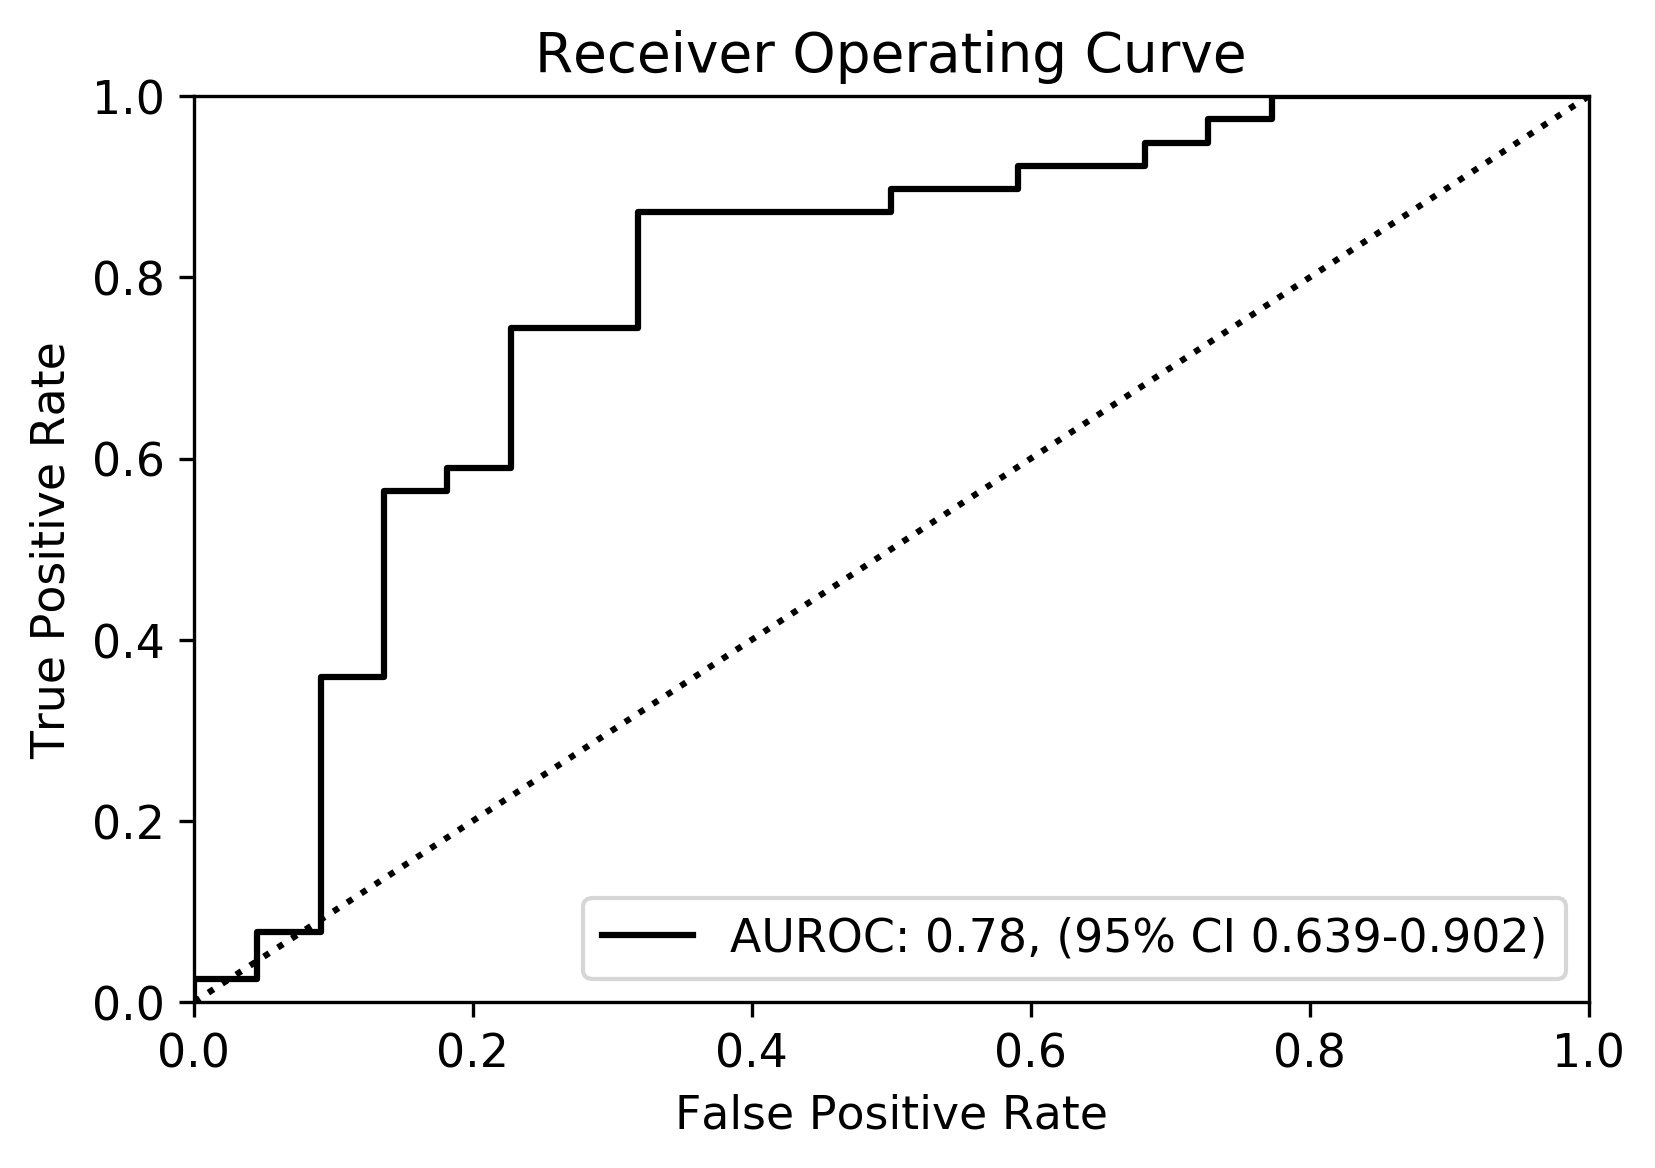

In [122]:
def get_auc_plot(clf,mean,lowerbound,upperbound,index_tpl):
    """
    Function to plot a Receiver Operating Characteristic
    
    Ripped from Sklearn documentation
    
    Parameters
    ----------
    clf: sklearn.Estimator
        A fitted sklearn model
    mean: float64
        Bootstrap mean of AUROC
    lowerbound: float64
        Bootstrap 2.5% quantile of AUROC
    upperbound: float64
        Bootstrap 97.5% quantile of AUROC
    index_tpl: tuple
        Indices of testing data for mean, lower and upper bound results
        
    Returns
    -------
    None
    
    """
    from sklearn.metrics import roc_auc_score
    
    #Get test set scores
    y_pred_proba = clf.predict_proba(x_test)[::,1]
    test_fpr, test_tpr, _ = roc_curve(y_test,  y_pred_proba)
    test_set = roc_auc_score(y_test,y_pred_proba)
    
    #Get lowerbound
    y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[1]])[::,1]
    lower_fpr, lower_tpr, _ = roc_curve(y_test[index_tpl[1]],  y_pred_proba)
    
    #Get upperbound
    y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[2]])[::,1]
    upper_fpr, upper_tpr, _ = roc_curve(y_test[index_tpl[2]],  y_pred_proba)
    
    label_string = f'AUROC: {np.round(test_set,3)}, (95% CI {lowerbound}-{upperbound})'
    print()
    plt.title('Receiver Operating Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.plot([1, 0], [1, 0],"k:")
    plt.plot(test_fpr,test_tpr,label=label_string,color='black')
    plt.legend(loc=4)
    plt.show()
    
auc_mean,auc_lowerbound,auc_upperbound,index_tpl = mean_95ci(bootstrap_dict['auc'],bootstrap_dict['indices'])
get_auc_plot(best_model,auc_mean,auc_lowerbound,auc_upperbound,index_tpl)

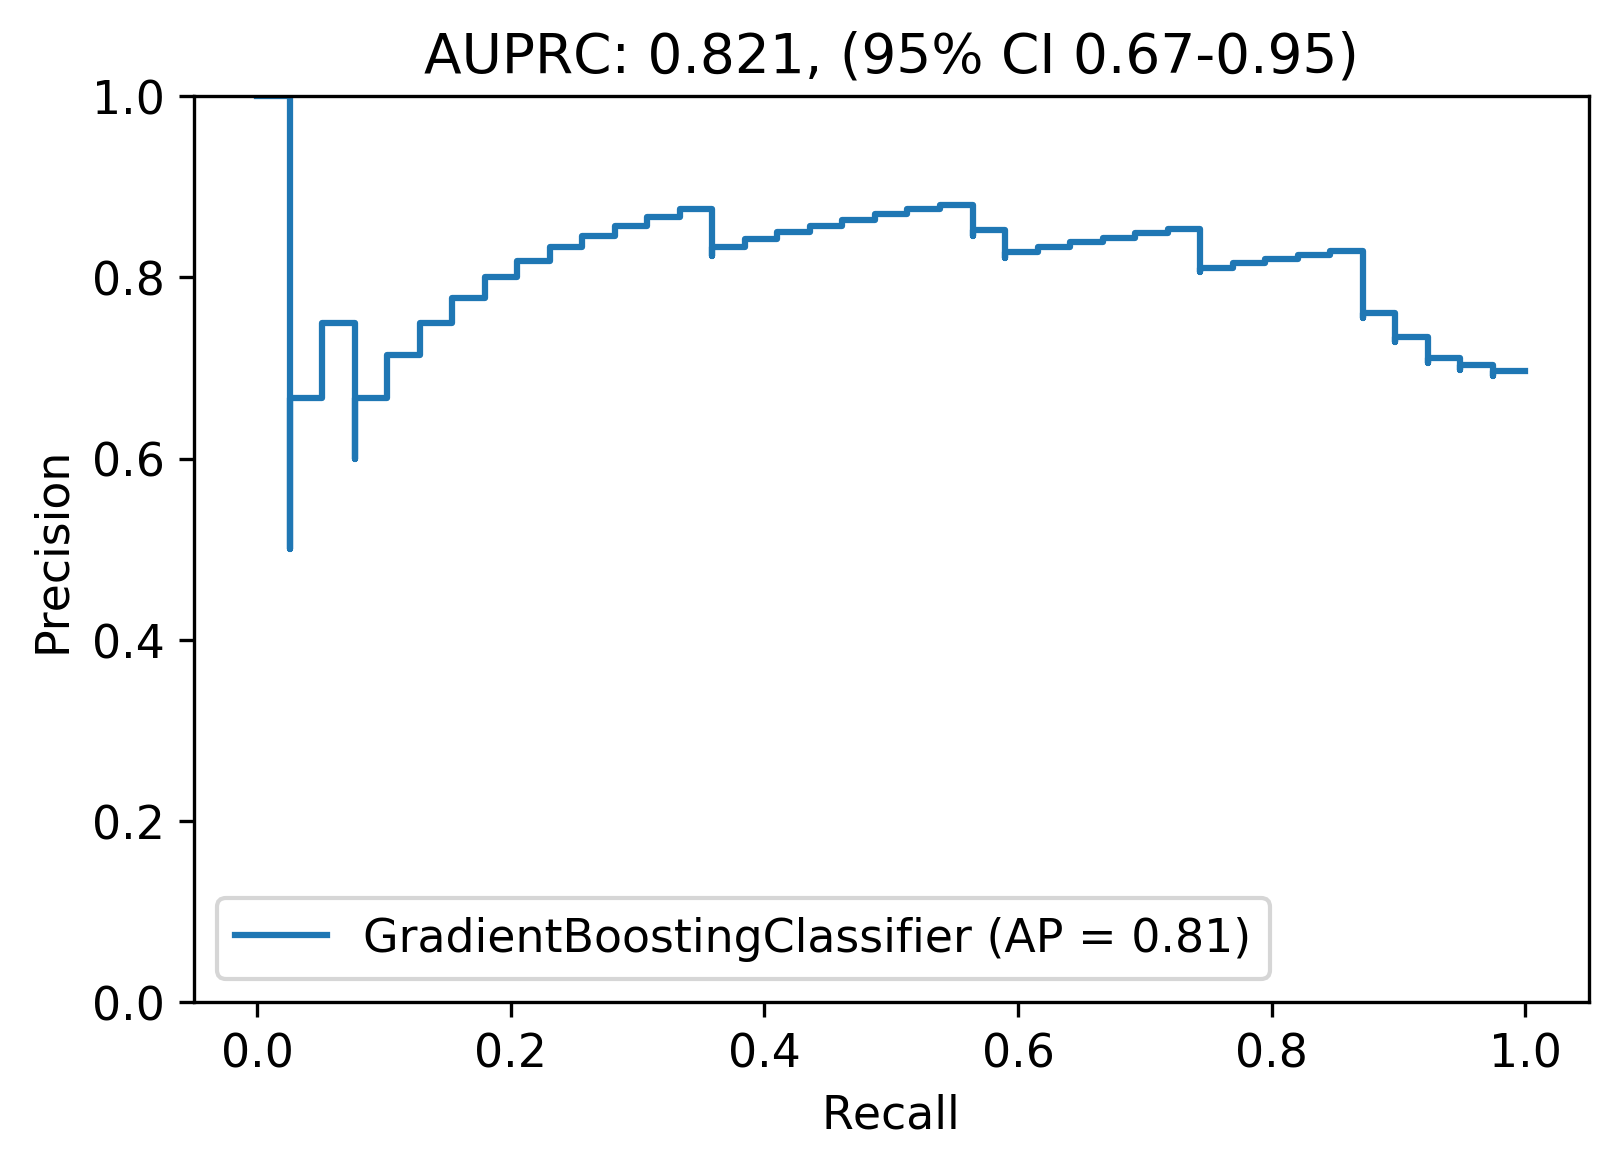

In [109]:
def get_auprc_plot(clf,mean,lowerbound,upperbound):
    
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(x_test)[:, 1]
    else:  # use decision function
        y_score = clf.decision_function(x_test)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
                
    label_string = f'AUPRC: {mean}, (95% CI {lowerbound}-{upperbound})'
    disp = plot_precision_recall_curve(clf, x_test, y_test)
    disp.ax_.set_ylim(0,1.0)
    disp.ax_.set_title(label_string)
    
auprc_mean,auprc_lowerbound,auprc_upperbound,_ = mean_95ci(bootstrap_dict['auprc'],bootstrap_dict['indices'])
get_auprc_plot(best_model,auprc_mean,auprc_lowerbound,auprc_upperbound)

In [121]:
print('Additional Metrics')
y_score = clf.predict_proba(x_test)[:, 1]
tn, fp, fn, tp = confusion_matrix(y_test, y_score >= 0.5).ravel()
sensitivity = tp/(tp+fn) 
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)

_,sensitivity_lowerbound,sensitivity_upperbound,_ = mean_95ci(bootstrap_dict['sensitivity'],bootstrap_dict['indices'])
print(f'Sensitivity: {np.round(sensitivity,3)} (95% CI {sensitivity_lowerbound}-{sensitivity_upperbound})')
_,specificity_lowerbound,specificity_upperbound,_ = mean_95ci(bootstrap_dict['specificity'],bootstrap_dict['indices'])
print(f'Specificity: {np.round(specificity,3)} (95% CI {specificity_lowerbound}-{specificity_upperbound})')
_,ppv_lowerbound,ppv_upperbound,_ = mean_95ci(bootstrap_dict['ppv'],bootstrap_dict['indices'])
print(f'Positive Predictive Value: {np.round(ppv,3)} (95% CI {ppv_lowerbound}-{ppv_upperbound})')

Additional Metrics
Sensitivity: 0.769 (95% CI 0.628-0.892)
Specificity: 0.682 (95% CI 0.471-0.864)
Positive Predictive Value: 0.811 (95% CI 0.667-0.925)


# Feature Importance

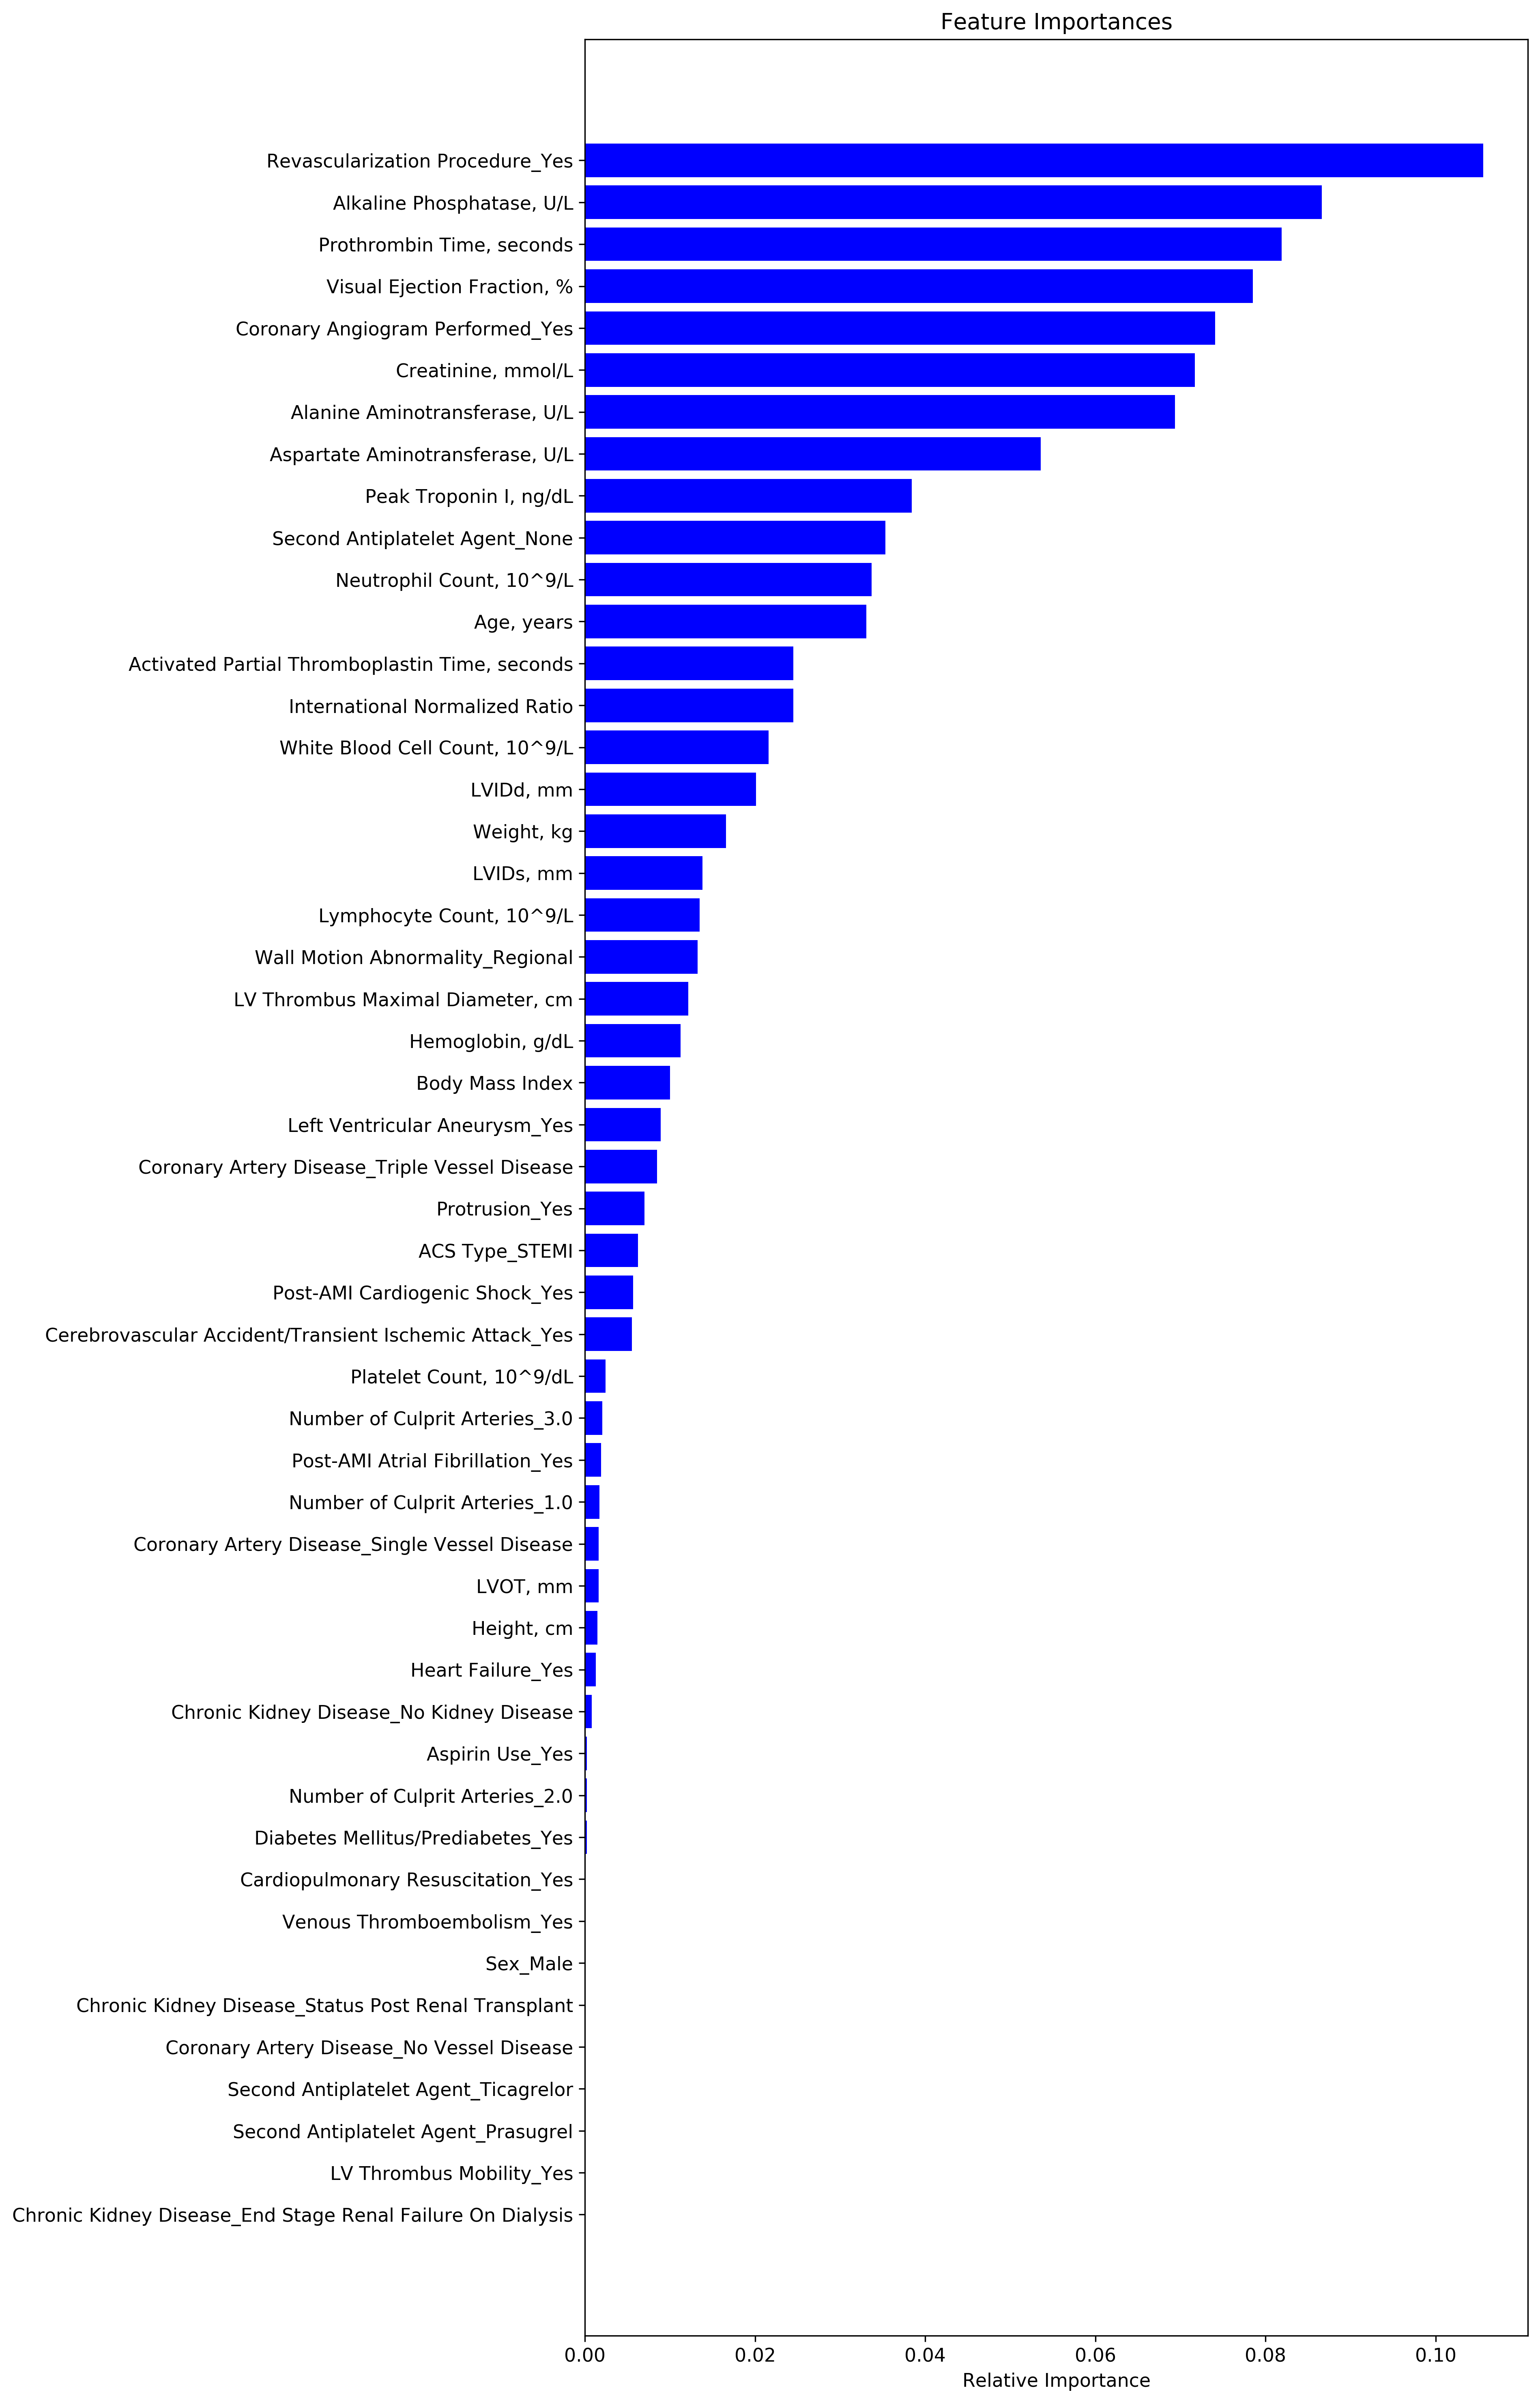

In [30]:
if hasattr(best_model,'feature_importances_'):
    features = x_test.columns
    importances =  best_model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10,25))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Calibration

Best Model:
	Brier: 0.174
	Precision: 0.811
	Recall: 0.769
	F1: 0.789

Best Model + Isotonic:
	Brier: 0.192
	Precision: 0.806
	Recall: 0.744
	F1: 0.773

Best Model + Sigmoid:
	Brier: 0.189
	Precision: 0.829
	Recall: 0.744
	F1: 0.784



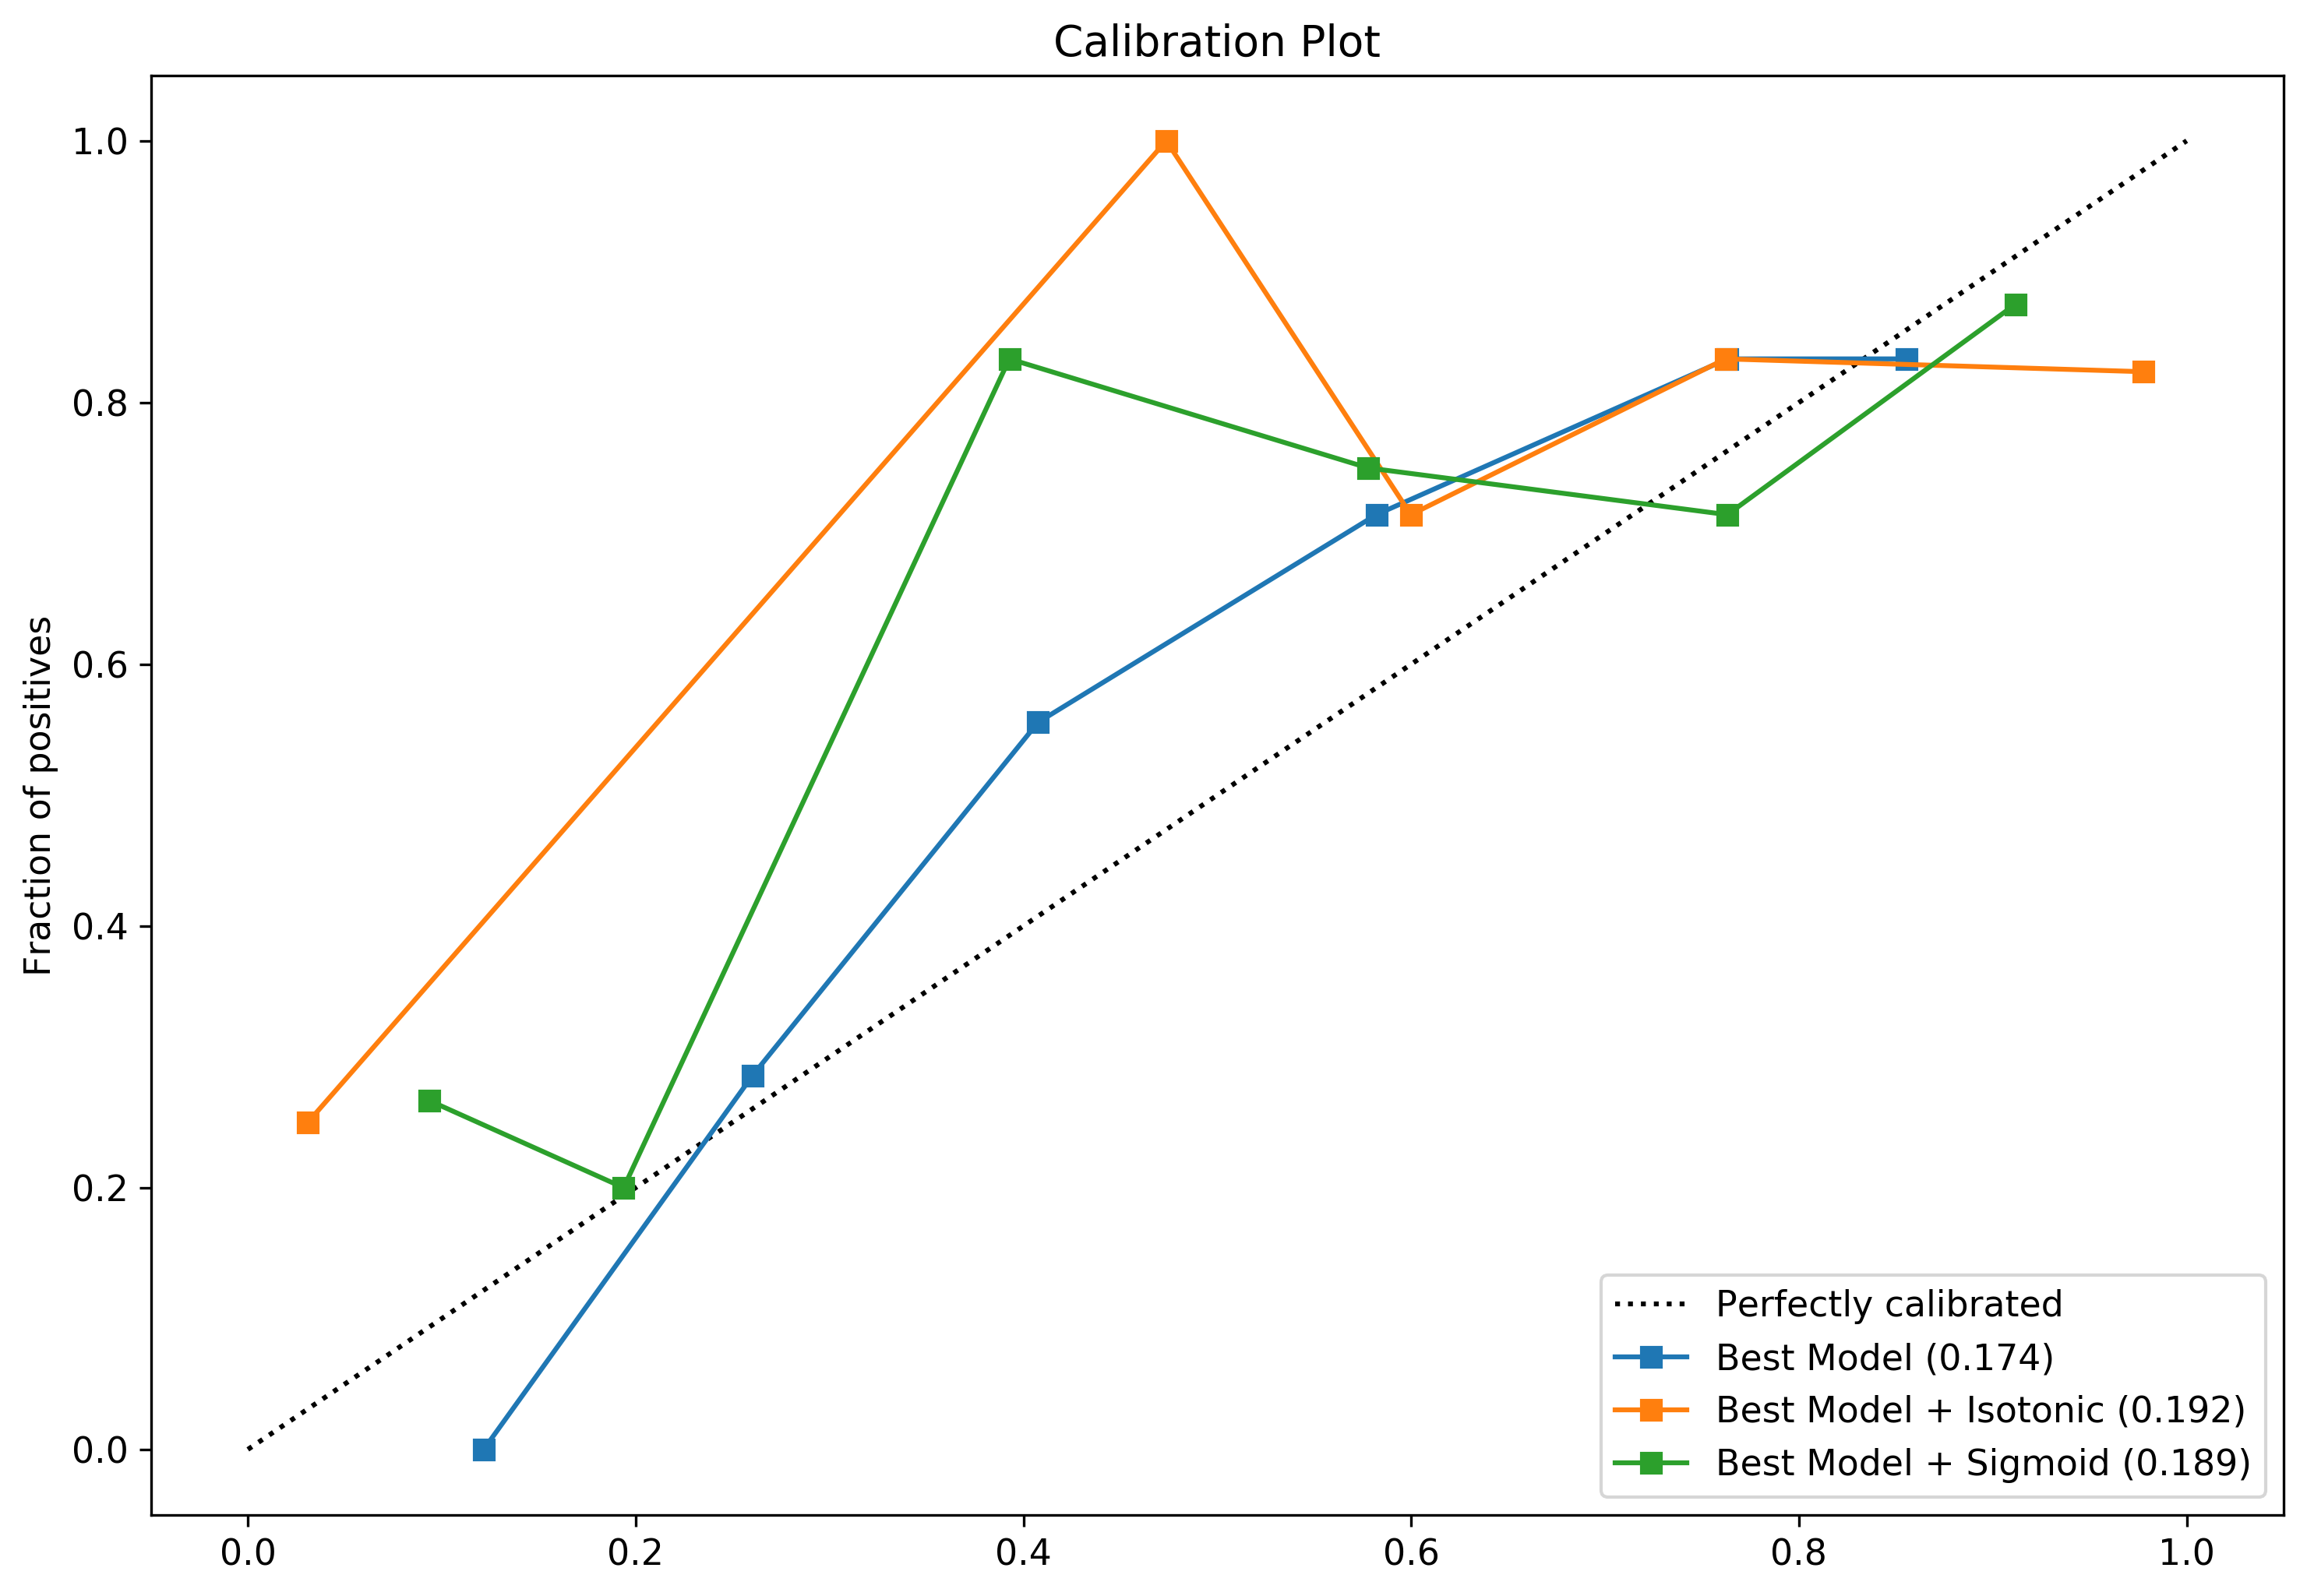

In [105]:
def calibrate(model,x_train,y_train,x_test,y_test,cv,plot_only):
    
    def plot_calibration_curve(est, name, fig_index,cv='prefit'):
        """
        Ripped from: https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py
        """        
        
        
        """Plot calibration curve for est w/o and with calibration. """
        # Calibrated with isotonic calibration
        isotonic = CalibratedClassifierCV(est, cv=cv, method='isotonic')

        # Calibrated with sigmoid calibration
        sigmoid = CalibratedClassifierCV(est, cv=cv, method='sigmoid')

        fig = plt.figure(fig_index, figsize=(10, 10))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

        #ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        for clf, name in [(est, name),
                          (isotonic, name + ' + Isotonic'),
                          (sigmoid, name + ' + Sigmoid')]:
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            if hasattr(clf, "predict_proba"):
                prob_pos = clf.predict_proba(x_test)[:, 1]
            else:  # use decision function
                prob_pos = clf.decision_function(x_test)
                prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

            clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
            
            print("%s:" % name)
            print("\tBrier: %1.3f" % (clf_score))
            print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
            print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
            print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

            fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=6)

            ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

            #ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
            #         histtype="step", lw=2)

        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title('Calibration Plot')

        #ax2.set_xlabel("Mean predicted value")
        #ax2.set_ylabel("Count")
        #ax2.legend(loc="upper center", ncol=2)
        plt.tight_layout()

    plot_calibration_curve(model, "Best Model", 1)
    

calibrate(best_model,x_train,y_train,x_test,y_test,cv='prefit',plot_only=False)

# Final Plots

In [129]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 11})

title_auc='Figure 1A. Receiver Operating Curve'
title_calibration='Figure 1B. Calibration Plot'
clf = best_model

from sklearn.metrics import roc_auc_score
    
#Get test set scores
y_pred_proba = clf.predict_proba(x_test)[::,1]
test_fpr, test_tpr, _ = roc_curve(y_test,  y_pred_proba)
test_set = roc_auc_score(y_test,y_pred_proba)

y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[1]])[::,1]
lower_fpr, lower_tpr, _ = roc_curve(y_test[index_tpl[1]],  y_pred_proba)

y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[2]])[::,1]
upper_fpr, upper_tpr, _ = roc_curve(y_test[index_tpl[2]],  y_pred_proba)

label_string = f'AUROC: {np.round(test_set,2)} (95% CI {auc_lowerbound}-{auc_upperbound})'

prob_pos = clf.predict_proba(x_test)[::,1]
clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=6)

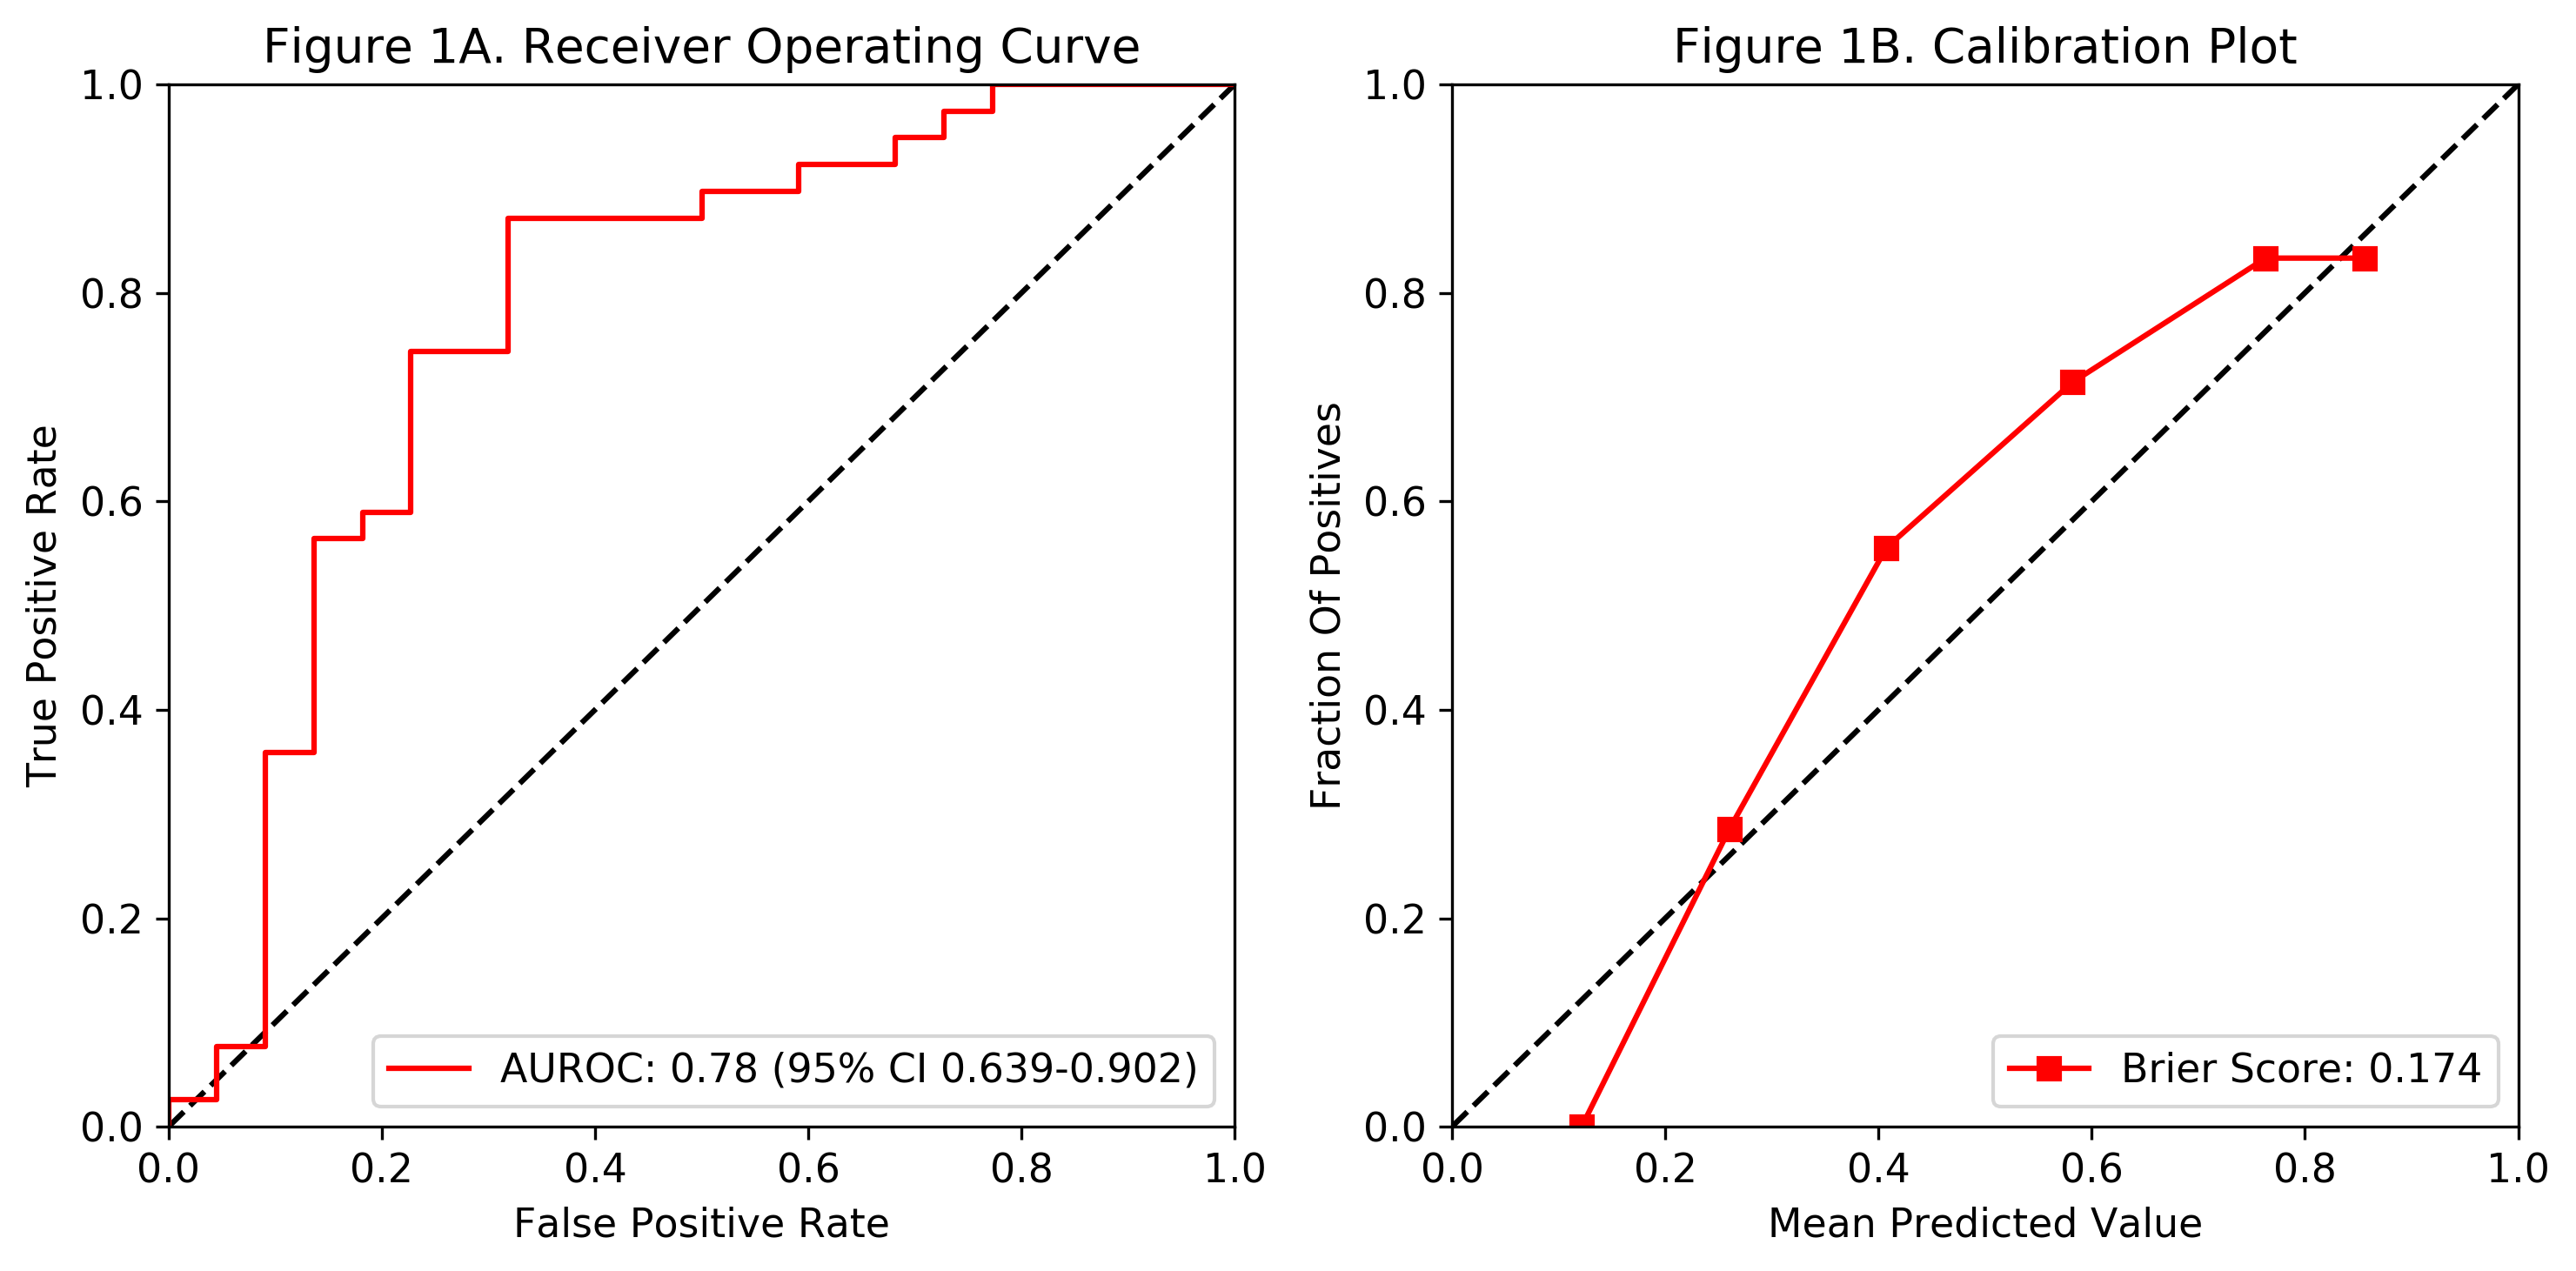

In [130]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title(title_auc)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([1, 0], [1, 0],"k--")
plt.plot(test_fpr,test_tpr,label=label_string,color='red')
plt.legend(loc=4)

plt.subplot(1,2,2)
plt.title(title_calibration)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel("Fraction Of Positives")
plt.xlabel("Mean Predicted Value")
plt.plot([1, 0], [1, 0],"k--")
plt.plot(mean_predicted_value, fraction_of_positives, "rs-",label=f'Brier Score: {np.round(clf_score,3)}')
plt.legend(loc="lower right")
plt.savefig('Figure 1.png')
plt.tight_layout()

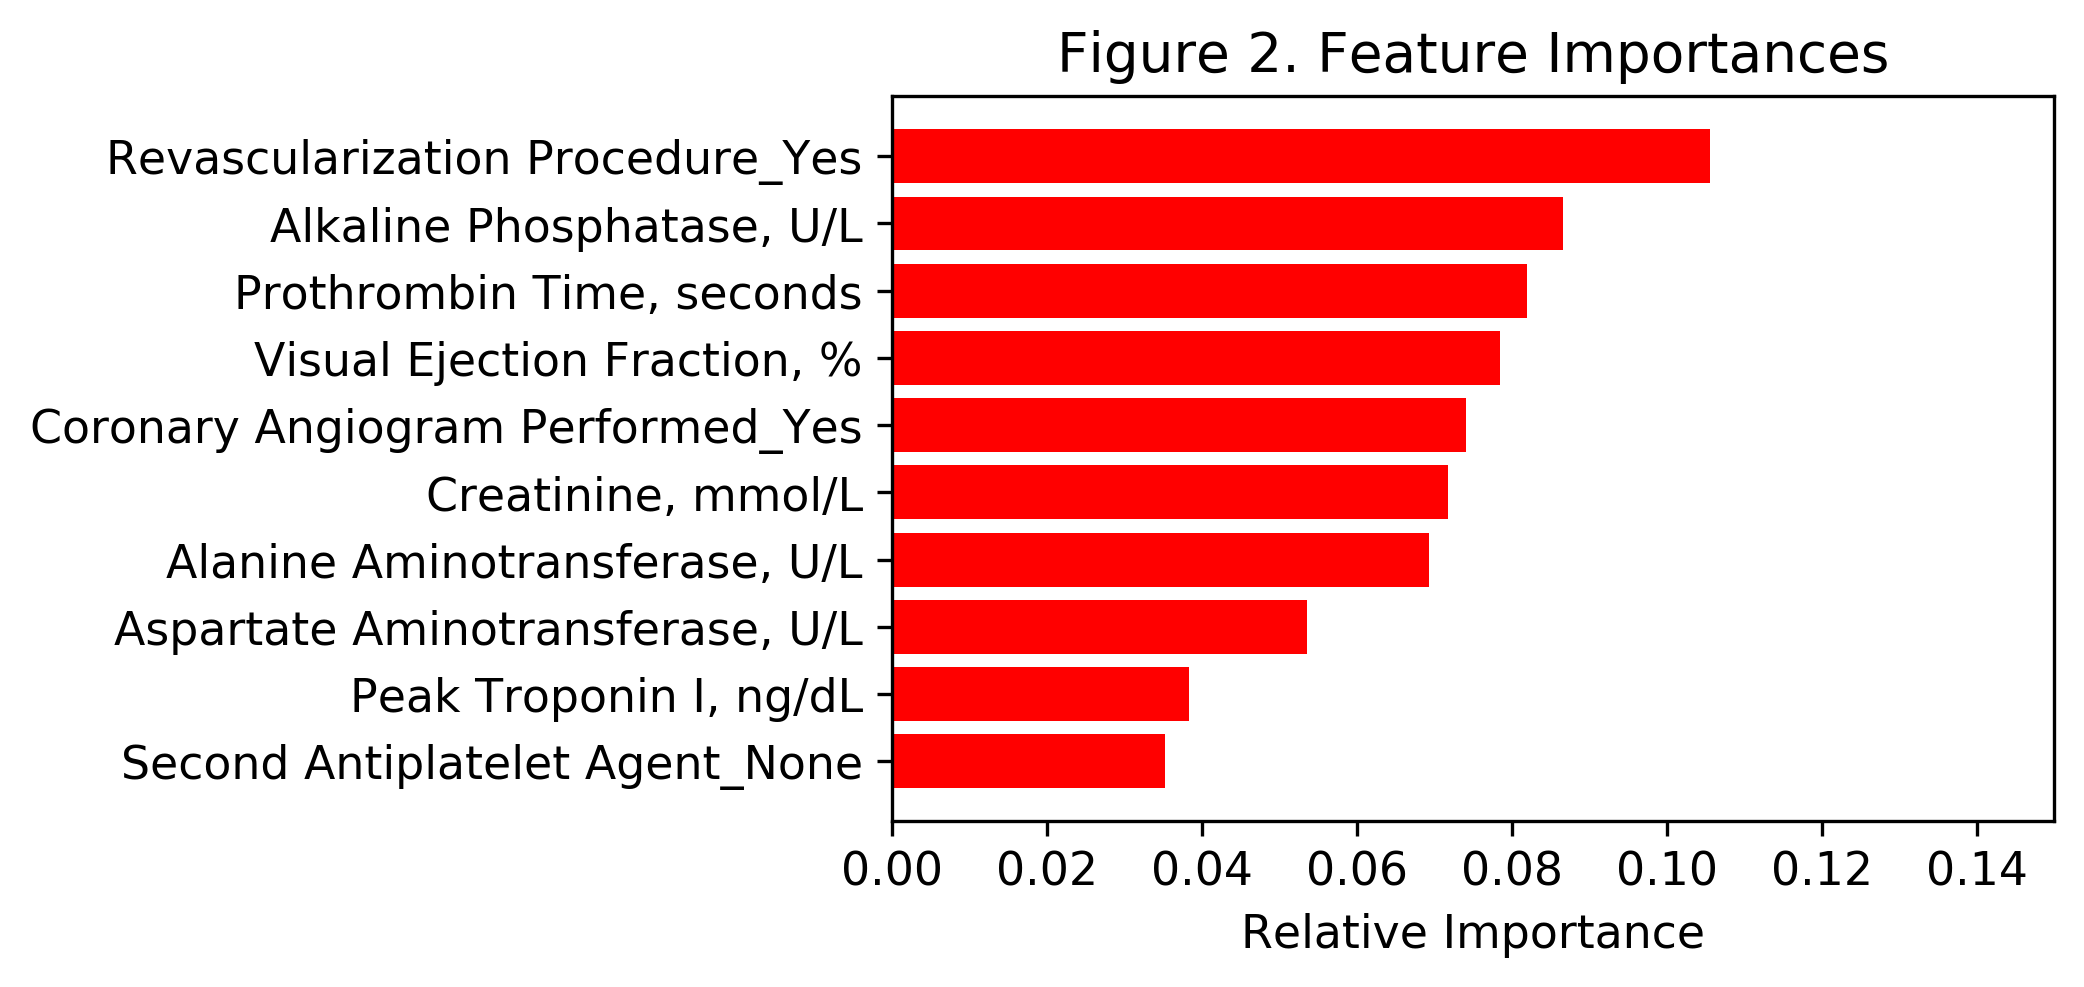

In [128]:
if hasattr(best_model,'feature_importances_'):
    features = x_test.columns
    importances =  best_model.feature_importances_
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(5,3.2))
    plt.title('Figure 2. Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.xlim(0,0.15)
    plt.savefig('Figure 2.png')
    plt.show()